# STL10 PCA and GMM Experiment
**by Pio Lauren T. Mendoza**

In this notebook the Principal Component Analysis (PCA) and Gaussian Mixture Models will be built from scratch by only using pure python and numpy. Their performance will be evaluated under various conditions.

### Importing Modules

In [79]:
from matplotlib.colors import LogNorm
from numpy.random import default_rng
from pathlib import Path
from PIL import Image
from scipy import linalg
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from torchvision import datasets

import gc
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

rng = default_rng()

%matplotlib inline
# %load_ext blackcellmagic

## Data Preparation

In this section data will be extracted, loaded, and transformed to fit the need of the following PCA and GMM experiments.

### Data Reshaping and Normalization Functions
The following are data manipulation functions. PCA uses vectors to compute for its code and reconstructed data. Images are data stored in matrix. Flattening a stack of images will make the computation easier. Function `flatten_images` will be used for this purpose. Functions `to_column_vector` and to `to_row_vector` transforms 1 dimensional vector in to a 2 dimensional vector to make numpy functional calls easier. The `normalize` function normalizes a stack of column vectors of data. It subtracts the mean per column and divides data mean centered data by its standard deviation.

In [2]:
def flatten_images(data):
    """
    Flatten stack of images to create a column vectors of data.

    Parameters
    ----------
    data : numpy.ndarray
        Numpy array of data.
        Images stacked on the 0th axis.
        data.shape = (num_images, res_y, res_x)

    Returns
    -------
    numpy.ndarray
        Flattened images. Each images is reshaped
        in to a column vector and are stacked along
        the 1st axis.
        shape = (num_pixels_per_image, num_images)
    """
    data_len = len(data)
    return data.reshape((data_len, -1)).T


def to_column_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[:, None]


def to_row_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[None, :]


def normalize(data):
    """
    Normalizes the given data.

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)

    Returns
    -------
    numpy.ndarray
        Returns the normalized data.
    float
        Returns the mean per feature.
    float
        Returns the standard deviation per feature.
    """
    data_mean = np.mean(data, axis=1, keepdims=True)
    data_std = np.std(data, axis=1, keepdims=True)

    return (data - data_mean) / data_std, data_mean, data_std


def denormalize(data, mean, std):
    """
    Denormalizes a give data

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)
    mean : float
        The mean per feature.
        shape = (num_features, 1)
    std : float
        The standard deviation per feature.
        shape = (num_features, 1)

    Returns
    -------
    numpy.ndarray
        Returns the denormalized data.
    """
    return data * std + mean

### Data Loading

The `torchvision` library will be used for dataloading. For more information about the STL10 [\[1\]](#1) dataset api of `torchvision` you may visit the [documentation](https://pytorch.org/vision/stable/_modules/torchvision/datasets/stl10.html). STL10 unlabeled split dataset has 100k images but for this experiment only 10k images will be used. This 10k images will be sampled in the STL10 unlabeled split. The test split of the STLL10 dataset will be used to evaluate the effectiveness of PCA to the unseen data.

In [3]:
ds_unlabeled = datasets.STL10(root="./data", split="unlabeled", download=True)
classes = ds_unlabeled.classes
print(f"STL10 unlabeled split size: {len(ds_unlabeled)}")

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
STL10 unlabeled split size: 100000


In [4]:
ds_test = datasets.STL10(root="./data", split="test")
print(f"STL10 test split size: {len(ds_test)}")

STL10 test split size: 8000


In [5]:
ds_train = datasets.STL10(root="./data", split="train")
print(f"STL10 train split size: {len(ds_train)}")

STL10 train split size: 5000


The stacks of images for both the unlabeled and test splits is first converted to a grayscale image from RGB. This conversion was done due to computational power limitation. The PCA experiment will only resolve on the principal components of the grayscale dataset.  
After converting the images to grayscale it was then reshaped into column vectors which where stacks horizontally (along axis 1). This was done since PCA uses stack of data in a vector.

In [6]:
DATASET_UNLABELED_SIZE = 10_000
IMAGE_RESOLUTION = ds_unlabeled.data.shape[2:]
RESIZE_RESOLUTION = (72, 72)

In [7]:
data_unlabeled_RGB = rng.choice(
    ds_unlabeled.data, size=DATASET_UNLABELED_SIZE, replace=False
)

data_unlabeled = np.empty((DATASET_UNLABELED_SIZE, *IMAGE_RESOLUTION))

for idx, image in enumerate(data_unlabeled_RGB):
    data_unlabeled[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_unlabeled_flattened = flatten_images(data_unlabeled)

In [8]:
data_test = np.empty((len(ds_test), *IMAGE_RESOLUTION))

for idx, image in enumerate(ds_test.data):
    data_test[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_test_flattened = flatten_images(data_test)
data_test_labels = ds_test.labels

In [9]:
data_train = np.empty((len(ds_train), *IMAGE_RESOLUTION))

for idx, image in enumerate(ds_train.data):
    data_train[idx] = (
        np.asarray(Image.fromarray(image.transpose((1, 2, 0))).convert("L")) / 255
    )

data_train_flattened = flatten_images(data_train)
data_train_labels = ds_train.labels

Force garbage collection / memory free up

In [10]:
del ds_unlabeled, ds_train, ds_test, data_unlabeled, data_unlabeled_RGB, data_train, data_test
gc.collect()

273

### Plotting Function
The function `plot_sample` will be used to plot some images of a given data.

In [75]:
def plot_sample(data, indices, title, shape = None):
    """
    Plots the sampled images from data.

    Parameters
    ----------
    data : numpy.ndarray
        A stack of images stored in numpy array.
    indices: list[int]
        List of image indices that will be plotted.
    title: str
        Descriptive title of the figure.
    shape: tuple[int]
        New shape size of data.
    """
    figure = plt.figure()
    plt.suptitle(title, fontsize=12)
    num_images = len(indices)
    for count, idx in enumerate(indices, 1):
        figure.add_subplot(int(np.ceil(num_images/3)), 3, count)

        img = data[:, idx]
        if shape:
            img = img.reshape(shape)

        
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    # plt.tight_layout()

def plot_cluster_dist(clusters, n_clusters, title):
    """
    Plots clusters distribution

    Parameters
    ----------
    clusters : numpy.ndarray
        Array of cluster assignment.
        shape = (n_samples,)
    n_clusters : int
        Number of clusters
    title : str
        Plot title
    """
    plt.figure()
    labels, counts = np.unique(clusters, return_counts=True)
    plt.bar(labels, counts)
    plt.xticks(list(range(n_clusters)));
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    plt.title(title)

## Principal Component Analysis

High dimensional data are is ubiquitous these days. These high dimensional data are expressed in terms of features. For example an image of cat maybe defined by $1024\times1024$ RGB image. Each pixel represent an information which comprises a high dimensional data. But, we don't need the whole $1024\times1024$ pixels to understand that the image has a cat on it. These high dimensional data are usually over defined. They are composed of redundant information which has correlation which can be utilized for dimensionality reduction. Principal component analysis is an algorithm for linear data dimensionality reduction [\[2\]](#2). PCA tries to find the minimum set of basis that can represent the data in a compact manner. These basis vectors were called as *"best fitting lines"* in the original paper of Pearson in 1901 [\[3\]](#3).

Using PCA we would like to find $\boldsymbol{\tilde{x}_n}$ which is the projections of the sample $\boldsymbol{x_n}$ into a lower dimensionality [\[2\]](#2). This could also be thought of as a change of basis [\[4\]](#4). Consider an IID data $\boldsymbol{X} = \{\boldsymbol{x_1},...,\boldsymbol{x_N}\}$, $\boldsymbol{x_n} \in \mathbb{R}^D$, with mean $\boldsymbol{0}$ and has data covariance matrix 

$$S = \frac{1}{N} \sum_{n=1}^{N} \boldsymbol{x_n} \boldsymbol{x_n}^T =\frac{1}{N} \boldsymbol{X}\boldsymbol{X}^T$$

There exist a low-dimensional compressed representation (code)

$$\boldsymbol{z_n} = \boldsymbol{B}^T \boldsymbol{x_n} \in \mathbb{R}^M$$

Where the orthonormal projection matrix is

$$\boldsymbol{B} := [\boldsymbol{b_1},...,\boldsymbol{b_M}] \in \mathbb{R}^{D\times M}$$

The columns of $\boldsymbol{B}$ are orthogonal with each other and has a magnitude of 1.

The graphical representation of PCA is shown below. The first arrow, original data to compressed data, can be imagined as an encoder. On the otherhand, the second arrow can be imagined as a decoder. But unlike modern autoencoder networks PCA, as seen from the formula, is linear transformation.

![Graphical Representation of PCA](pca_illustration.png)


### PCA Dimensionality Reduction

For example you recorded 100 samples of data with 2 features, feature 1 and feature 2. The samples were IID. You plotted the samples which is shown below. As seen the seeemingly to have trend of line going up. We can define a best fitting line which along this trend, the black line formed diagonally up. The variance along this line is large. The extra variation not captured by this line can be projected in the orthogonal line, the short black line formed diagonnaly down. The variance along this line is small. As seen, we could represent the data by only using the diagonally up line while losing only a minimal information. This transformation is how PCA works. To formalize, this black lines are the orthonormal basis vectors of $\boldsymbol{B}$ which is also called as the principal components. We always want to pick the principal component with great variance to maximize the information we acquire.

With this, we may ask how is this orthonomal basis determined? As of now we only based it on the visual inspection of the plot of the graph. But, how about the data with many features, where PCA is heavily used?

Text(0, 0.5, 'Feature 2')

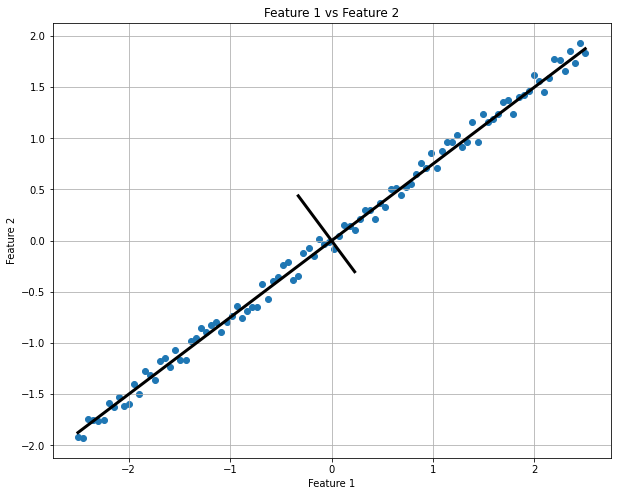

In [19]:
x = np.linspace(-2.5, 2.5, 100)
y = 3 / 4 * x
y_T = -4 / 3 * x[43:55]
y_noisy = y + 0.25 * rng.random(100) - 0.125
plt.figure(figsize=(10, 8))
plt.plot(x, y, "k-", linewidth=3)
plt.scatter(x, y_noisy)
plt.plot(x[43:55], y_T, "k-", linewidth=3)
plt.grid(visible=True, which="both")
plt.title("Feature 1 vs Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

### PCA Steps

PCA is generally done in 4 keys steps.

1. **Mean subtraction**. This is done by subtracting mean of each feature in each feature.
2. **Standardization**. This is done by dividing each feature by it standard deviation. These first two steps are done by the `normalize` method of the `class PCA`.
3. **Eigendecmoposition of the covariance matrix**. To ensure a good reconstuction of $\boldsymbol{x_n}$ the loss function $\left\lVert\boldsymbol{x_n}-\boldsymbol{\tilde{x}_n}\right\rVert^2$ must be minimized. The objective function must be minimized

    $$\boldsymbol{J_M} := \frac{1}{N}\sum_{n=1}^N \left\lVert\boldsymbol{x_n}-\boldsymbol{\tilde{x}_n}\right\rVert^2$$

    This is minimized when $\boldsymbol{\tilde{x}_n}$ is almost equal to, or at best equal to, $\boldsymbol{x_n}$.

    $$\boldsymbol{\tilde{x}_n} = \boldsymbol{B}_M\boldsymbol{B}_M^T\boldsymbol{x}_n$$

    The best $\boldsymbol{B}_M$ can be computed in two ways.
    1. Eigendecomposition of the covariance matrix
        This done by finding the eigen values and eigen vectors on the covariance matrix of the input data
        
        $$\boldsymbol{S} = \boldsymbol{BDB^{-1}}$$

        Where $\boldsymbol{B}$ are the eigen vectors and $\boldsymbol{D}$ are the eigen values. The eigen values can also be interpreted as the variances per principal component.
        
    2. Singular Value Decomposition of input data
        The second method would be finding the SVD of the input data $\boldsymbol{X}$.

        $$X = \boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^T$$

        Since 

        $$ \boldsymbol{S} = \frac{1}{N}\boldsymbol{X}\boldsymbol{X}^T = \frac{1}{N}\boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^T\boldsymbol{V}^T\boldsymbol{\Sigma}\boldsymbol{U} = \frac{1}{N}\boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{\Sigma}^T\boldsymbol{U}^T $$

        Then the eigen vectors are $\boldsymbol{U}$ while the eigen values are $\boldsymbol{\Sigma}\boldsymbol{\Sigma}^T$

        Note that $\boldsymbol{V}$ and $\boldsymbol{U}$ are a unitary matrices.

    The eigen values are equivalent to the variances of each eigen vectors, $\sigma_i^2 \equiv \lambda_i$ [\[4\]](#4). To maximize the information we want to use the $M$ eigen vectors with highest variance. $M$ will be the dimension of the low-dimensional code.

    For the `class PCA` the SVD algorithm of `numpy` is used for computing the variances and orthonormal bases. This is implement in the method `get_projection_matrix`. To maximized dimensionality reduction the first $M$ largest eigenvalues must be selected for the projection matrix $\boldsymbol{B}$.


4. **Projection**. Projection is simply the computation of $\boldsymbol{\tilde{x}}_n$. This is done by performing the following matrix multiplications

    $$\boldsymbol{\tilde{X}} = \boldsymbol{BB^TX}$$

    This is handled by the `compress` and `reconstruct` methods of the `class PCA`. Method `compress` accepts normalized data and dim. It returns the code based on the computed projection matrix $\boldsymbol{B}$. In contrast, method `reconstruct` accepts the low-dimensional code and dim and it retruns the reconstructed data.

Note that an extra step of denormalizing the data can also be done.

In [18]:
class PCA:
    def __init__(self, data):
        """
        Constructs a PCA object.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of column vector of data.
            data.shape = (num_features, num_samples)
        """
        self.data = data
        self.normalized_data = None
        self.projection_matrix = None
        self.variances = None
        self.data_mean = None
        self.data_std = None

    def normalize(self):
        """
        Normalizes the given data.

        Stores
        ------
        normalized_data : numpy.ndarray
            Stores the normalized data.
        data_mean : numpy.ndarray
            Stores the mean per feature.
        data_std : numpy.ndarray
            Stores the standard deviation per feature.
        """
        data_mean = np.mean(self.data, axis=1, keepdims=True)
        data_std = np.std(self.data, axis=1, keepdims=True)

        self.normalized_data = (self.data - data_mean) / data_std
        self.data_mean = data_mean
        self.data_std = data_std

    def get_projection_matrix(self):
        """
        Computes for the eigen vectors and values.

        Stores
        -------
        projection_matrix : numpy.ndarray
            Stores the eigenvectors of data X
        variances : numpy.ndarray
            Stores the eigenvalues of data X
        """
        U, S, _ = np.linalg.svd(self.data)
        self.projection_matrix = U
        self.variances = np.square(S)/len(self.data)

    def save_projection_matrix(self, path):
        """
        Saves projection matrix to path.

        Paramaters
        ----------
        path : str | Path
            Path where to save the projection matrix.
        """
        np.save(path, self.projection_matrix)

    def load_projection_matrix(self, path):
        """
        Saves projection matrix to path.

        Paramaters
        ----------
        path : str | Path
            Path where to load the projection matrix from.
        """
        self.projection_matrix = np.load(path)

    def save_variances(self, path):
        """
        Saves projection matrix to path.

        Paramaters
        ----------
        path : str | Path
            Path where to save the variances.
        """
        np.save(path, self.variances)

    def load_variances(self, path):
        """
        Saves projection matrix to path.

        Paramaters
        ----------
        path : str | Path
            Path where to load the variances from.
        """
        self.variances = np.load(path)

    def compress(self, data, n_components):
        """
        Transforms data into low-dimensional compresion representation (code)

        Parameters
        ----------
        data : numpy.ndarray
            Stack of normalized column vector of data.
            data.shape = (num_features, num_samples)

        Returns
        -------
        numpy.ndarray
            Returns data projected on the projection matrix.
        """
        return np.matmul(self.projection_matrix[:, :n_components].T, data)

    def reconstruct(self, code, n_components):
        """
        Transforms data into low-dimensional compresion representation (code)

        Parameters
        ----------
        data : numpy.ndarray
            Stack of column vector of data.
            data.shape = (num_features, num_samples)

        Returns
        -------
        numpy.ndarray
            Returns normalized data projected on the projection matrix.
        """
        return np.matmul(self.projection_matrix[:, :n_components], code)

### Mean Squared Error

In [23]:
def compute_mse(data, data_reconstructed):
    return np.sum(np.square(data - data_reconstructed)) / data.size

In [24]:
def plot_mse(mse_per_dim, dims, title):
    plt.figure(figsize=(15, 7.5))
    plt.plot(dims, mse_per_dim, "o-")
    plt.grid(visible=True, which="both")
    plt.xlabel("Dimension of z")
    plt.ylabel("Mean Squared Error")
    plt.title(title)

### Building PCA

In [13]:
pca_stl10 = PCA(data_unlabeled_flattened)

pca_stl10.normalize()

projection_matrix_path = Path('projection_matrix.npy')
variances_path = Path('variances.npy')

if projection_matrix_path.is_file() and variances_path.is_file():
    pca_stl10.projection_matrix = np.load(projection_matrix_path)
    pca_stl10.variances = np.load(variances_path)
else:
    pca_stl10.get_projection_matrix()
    pca_stl10.save_projection_matrix(projection_matrix_path)
    pca_stl10.save_variances(variances_path)

### Variance and Dims

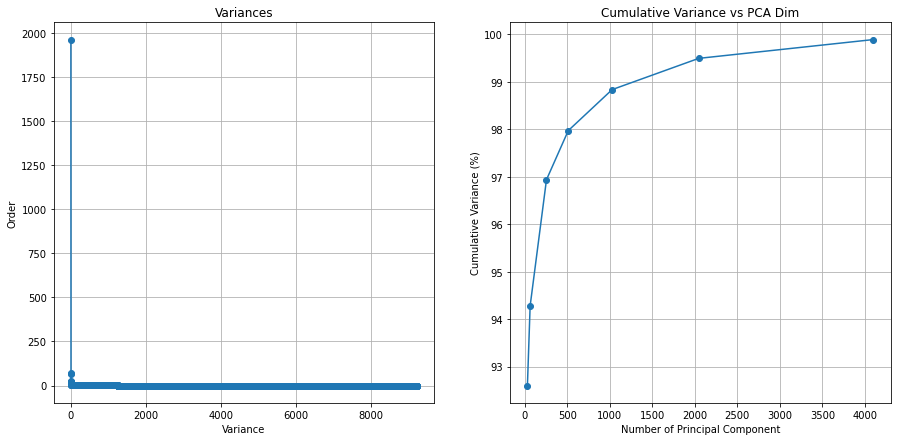

In [20]:
dims = [32, 64, 256, 512, 1028, 2046, 4098]

percent_variance_per_dim = []

for dim in dims:
    percent_variance = (
        np.sum(pca_stl10.variances[:dim]) / np.sum(pca_stl10.variances) * 100
    )
    percent_variance_per_dim.append(percent_variance)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(pca_stl10.variances, "o-")
plt.grid(visible=True, which="both")
plt.xlabel("Variance")
plt.ylabel("Order")
plt.title("Variances")
plt.subplot(1,2,2)
plt.plot(dims, percent_variance_per_dim, "o-")
plt.grid(visible=True, which="both")
plt.xlabel("Number of Principal Component")
plt.ylabel("Cumulative Variance (%)")
plt.title("Cumulative Variance vs PCA Dim");

Seen from the plot above, most of the variance is contained in the first principal component. It has a value of around 1950. The second variance drastically dropped to 71. Most of the information is contained in the first few principal components. The cumulative variance also proves this - when the dim is 32 it already contains around 92.5% of the total variance of the total variance. Also, notice that even though 2052 components are added from dim 2046 to 2098 there's only minimal increase in the cumulative variance.

### Dims vs MSE Unlabeled Dataset

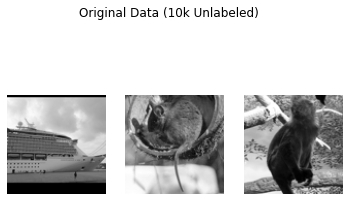

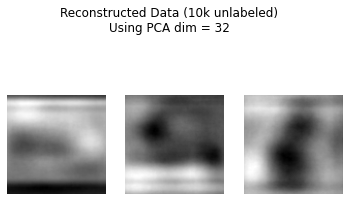

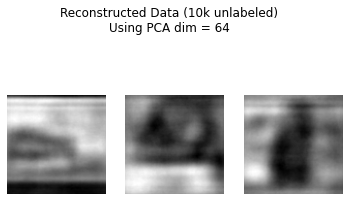

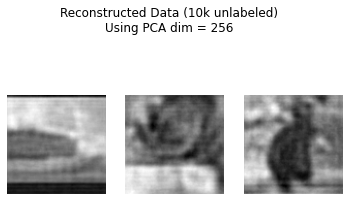

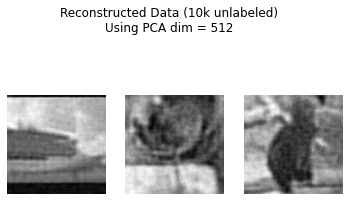

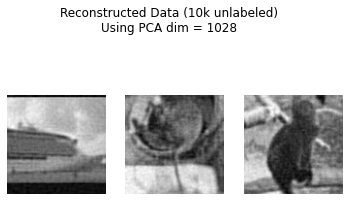

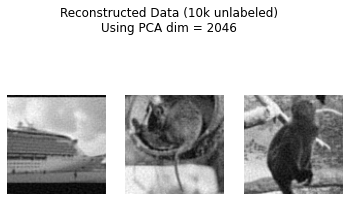

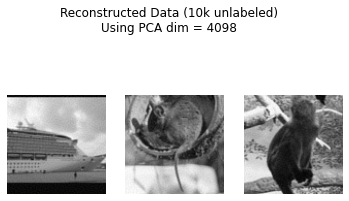

In [25]:
mse_per_dim = []

indices = list(range(3))

plot_sample(
    data_unlabeled_flattened, indices, "Original Data (10k Unlabeled)", (96, 96)
)

for dim in dims:
    code = pca_stl10.compress(pca_stl10.normalized_data, dim)
    reconstructed_data = denormalize(pca_stl10.reconstruct(code, dim), pca_stl10.data_mean, pca_stl10.data_std)
    mse = compute_mse(data_unlabeled_flattened, reconstructed_data)
    mse_per_dim.append(mse)
    plot_sample(
        reconstructed_data,
        indices,
        f"Reconstructed Data (10k unlabeled)\nUsing PCA dim = {dim}",
        (96, 96),
    )

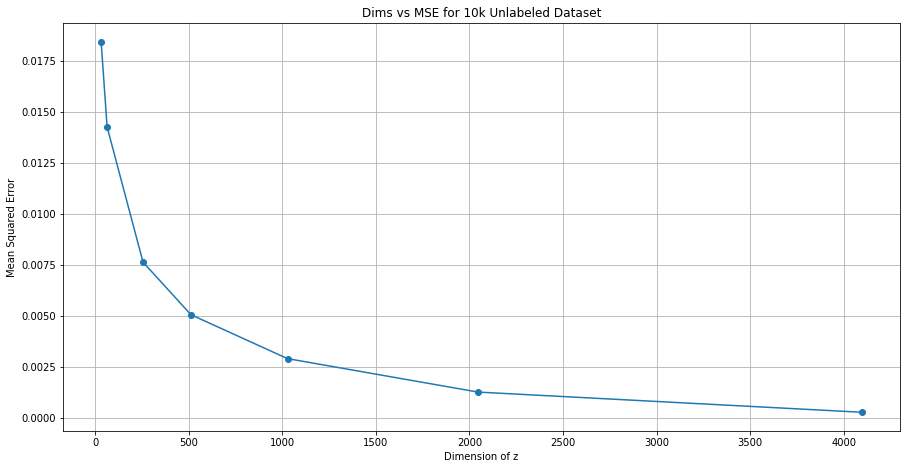

In [26]:
plot_mse(mse_per_dim, dims, "Dims vs MSE for 10k Unlabeled Dataset")

### Dims vs MSE Test Dataset

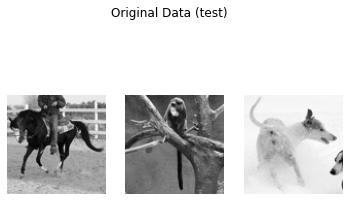

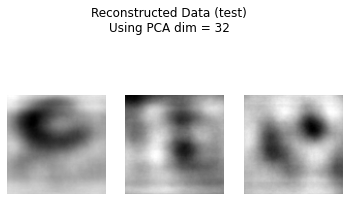

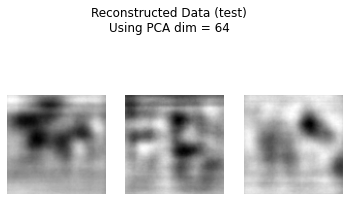

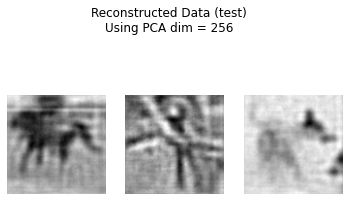

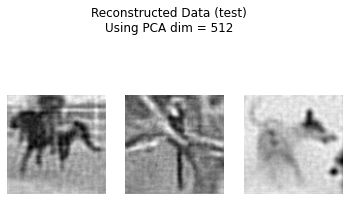

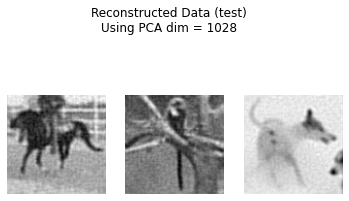

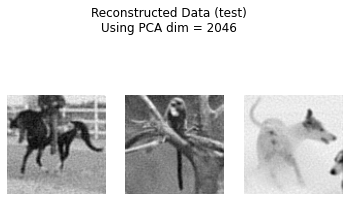

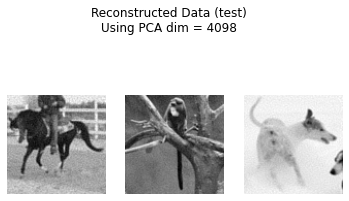

In [27]:
mse_per_dim = []

indices = list(range(3))

plot_sample(data_test_flattened, indices, "Original Data (test)", (96, 96))

normalized_test_data, mean, std = normalize(data_test_flattened)

for dim in dims:
    code = pca_stl10.compress(normalized_test_data, dim)
    reconstructed_data = denormalize(pca_stl10.reconstruct(code, dim), mean, std)
    mse = compute_mse(data_test_flattened, reconstructed_data)
    mse_per_dim.append(mse)
    plot_sample(
        reconstructed_data,
        indices,
        f"Reconstructed Data (test)\nUsing PCA dim = {dim}",
        (96, 96),
    )

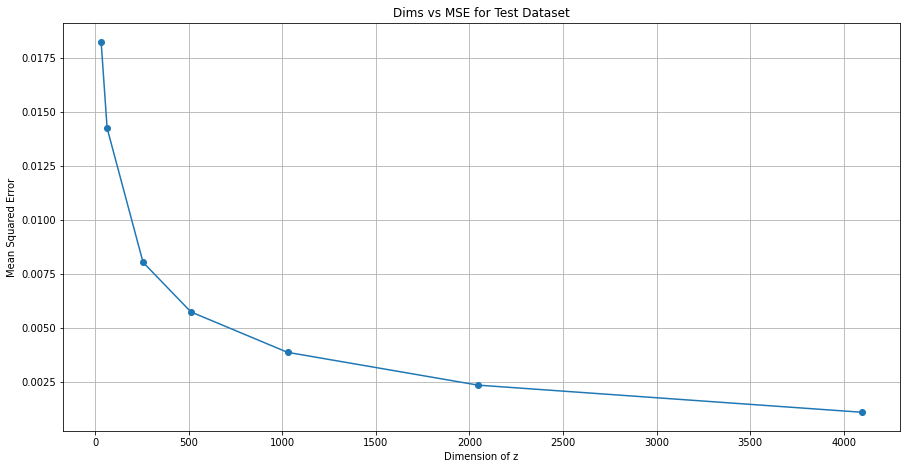

In [28]:
plot_mse(mse_per_dim, dims, "Dims vs MSE for Test Dataset")

### Optimal $\boldsymbol{z}$-dim

Both the MSE for the unlabeled and test splits follows the same trend. Their MSEs are exponentially decaying with respect to the number of dims. Their values are also relatively the near each other. The same trend as the cumulative variance is observe betweet the MSEs of dim 2046 and 4098. Even though 2052 components are added only minimal decrease is recorded in the MSE. 

For the images, at dim = 32 only blurred globs are seen in the reconstructed images. As the dim increases these globs gets more finer details. At dim = 512, the contour of the object in the images are now completely visible. At dim = 1028, the objects are visible but still a lot of fine information are missing. The images seems to be corrupted by some Gaussian noise. At dim = 2046, the images looks clearer. Lastly at dim = 4098, no noticeable difference is seen between it and dim 2046. More important details are stored in the first few principal components like general shape of the object. The great variance in the first few principal components discriminates the objects well. While the contribution of the principal components with small variance is attributed to the finer details of the image. 

Given this, the optimal $\boldsymbol{z}$-dim would be dim = 2046. Dim = 2046 captures most of the needed details while minimizing the number of components being used (lesser memory footprint). Also, since it uses lesser components the computation would be easier and faster.

In [100]:
optimal_dim = 1028

optimal_code_unlabeled_path = Path('optimal_code_unlabeled.npy')

if optimal_code_unlabeled_path.is_file():
    code_optimal = np.load(optimal_code_unlabeled_path)
else:
    # inpreparation for multivariate_gaussian pdf method
    code_optimal = pca_stl10.compress(pca_stl10.normalized_data, optimal_dim).T
    np.save(optimal_code_unlabeled_path, code_optimal)

In [99]:
!rm optimal_code_unlabeled.npy

In [106]:
normalized_train, mean_train, std_train = normalize(data_train_flattened)
code_train = pca_stl10.compress(normalized_train, optimal_dim).T

In [107]:
normalized_test, mean_test, std_test = normalize(data_test_flattened)
code_test = pca_stl10.compress(normalized_test, optimal_dim).T

## Gaussian Mixture Model

### GMM Steps

In [156]:
class GMM:
    def __init__(self, n_components, max_iter):
        """
        Constructs a GMM object

        Parameters
        ----------
        n_components : int
            Number of GMM components (classes)
        max_iter : int
            Number of EM-algorithm Iteration
        """
        self.n_components = n_components
        self.max_iter = max_iter

    def compute_nk(self):
        self.nk = self.responsibilities.sum(axis=0) + 10 * np.finfo(self.responsibilities.dtype).eps

    def compute_mus(self, data):
        self.mus = np.dot(self.responsibilities.T, data) / self.nk[:, np.newaxis]

    def compute_sigmas(self, data):
        reg_covar = 1e-6
        covariances = np.empty((self.n_components, self.n_features, self.n_features))
        for k in range(self.n_components):
            diff = data - self.mus[k]
            covariances[k] = np.dot(self.responsibilities[:, k] * diff.T, diff) / self.nk[k]
            covariances[k].flat[:: self.n_features + 1] += reg_covar

        self.sigmas = covariances

    def compute_precision_cholesky(self):
        precisions_chol = np.empty((self.n_components, self.n_features, self.n_features))
        for k, covariance in enumerate(self.sigmas):
            try:
                cov_chol = linalg.cholesky(covariance, lower=True)
            except linalg.LinAlgError:
                raise ValueError("Fitting the mixture model failed")
            precisions_chol[k] = linalg.solve_triangular(
                cov_chol, np.eye(self.n_features), lower=True
            ).T

        self.precisions_chol = precisions_chol
    
    def compute_pis(self):
        self.pis = self.nk / self.n_samples

    def initialize(self, data, mus, sigmas):
        """
        Sets initial values for mean, variance, and weights (pi).

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)
        mus : numpy.ndarray
            Vertically stacked means.
            mus.shape = (n_components, n_features)
        sigmas : numpy.ndarray
            Vertically stacked variances.
            mus.shape = (n_components, n_features, n_features)

        Stores
        ------
        mus : numpy.ndarray
            Vertically stacked means.
            mus.shape = (self.n_components, self.n_features)
        sigmas : numpy.ndarray
            Vertically stacked variances.
            mus.shape = (n_components, n_features, n_features)
        pi : numpy.ndarray
            Weight per component distribution.
            pi.shape = (n_components,)
        """
        self.n_samples, self.n_features = data.shape

        self.responsibilities = np.zeros((self.n_samples, self.n_components))
        label = (
            KMeans(
                n_clusters = self.n_components, n_init=1 
            )
            .fit(data)
            .labels_
        )
        self.responsibilities[np.arange(self.n_samples), label] = 1

        self.compute_nk()

        if mus is None:
            self.compute_mus(data)
        else:
            assert mus.shape == (
                self.n_components,
                self.n_features,
            ), "Shape must be (self.n_components, self.n_features)"
            self.mus = mus


        if sigmas is None:
            self.compute_sigmas(data)
        else:
            assert sigmas.shape == (
                self.n_components,
                self.n_features,
                self.n_features,
            ), "Shape must be (self.n_components, self.n_features, self.n_features)"
            self.sigmas = sigmas

        self.compute_precision_cholesky()
        self.compute_pis()

    
    def compute_log_det_cholesky(self):
        log_det_chol = np.sum(
            np.log(self.precisions_chol.reshape(self.n_components, -1)[:, :: self.n_features + 1]), 1
        )

        return log_det_chol

    def log_probabilities(self, data):
        """
        Predicts data probability for each distribution.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)

        Returns
        ------
        numpy.ndarray
            Horizontally probabilities per component.
            mus.shape = (num_samples, n_components)
        """
        n_samples = data.shape[0]

        log_det = self.compute_log_det_cholesky()

        log_prob = np.empty((n_samples, self.n_components))
        for k, (mu, prec_chol) in enumerate(zip(self.mus, self.precisions_chol)):
            y = np.dot(data, prec_chol) - np.dot(mu, prec_chol)
            log_prob[:, k] = np.sum(np.square(y), axis=1)

        return -0.5 * (self.n_features * np.log(2 * np.pi) + log_prob) + log_det

    def e_step(self, data):
        """
        Computes for responsibilities.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)

        Stores
        ------
        responsibilities : numpy.ndarray
            Responsibilities
            mus.shape = (num_samples, n_components)
        """
        log_probabilities = self.log_probabilities(data)

        log_probabilities_weighted = log_probabilities + np.log(self.pis)

        log_sum_probabilities_per_component = logsumexp(log_probabilities_weighted, axis=1, keepdims=True)

        with np.errstate(under="ignore"):
            self.responsibilities = np.exp(log_probabilities_weighted - log_sum_probabilities_per_component)

        return -log_sum_probabilities_per_component.sum()

    def m_step(self, data):
        """
        Recomputes for mu, sigma, and pi.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)

        Stores
        ------
        mus : numpy.ndarray
            Mean per component
            mus.shape = (n_component, n_features)
        sigmas : numpy.ndarray
            Responsibilities
            mus.shape = (n_component, n_features, n_features)
        pis : numpy.ndarray
            Responsibilities
            mus.shape = (n_components,)
        """
        self.compute_nk()
        self.compute_pis()
        self.compute_mus(data)
        self.compute_sigmas(data)
        self.compute_precision_cholesky()

    def fit(self, data, mus=None, sigma=None, log_interval=10):
        """
        Estimates the model parameters using EM algorithm.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)
        mus : numpy.ndarray
            Vertically stacked means.
            mus.shape = (n_components, n_features)
        sigmas : numpy.ndarray
            Vertically stacked variances.
            mus.shape = (n_components, n_features, n_features)
        """
        self.initialize(data, mus, sigma)

        nll = []
        for idx in range(1, self.max_iter+1):
            nll.append(self.e_step(data))
            self.m_step(data)
            if (idx % log_interval == 0):
                print(f"[{idx}/{self.max_iter}], NLL_Loss: {nll[-1]}")

        return nll

    def predict(self, data):
        """
        Predicts data clustar

        Parameters
        ----------
        data : numpy.ndarray
            Stack of row vector of data.
            data.shape = (num_samples, num_features)

        Returns
        -------
        numpy.ndarray
            Cluster
            shape = (num_samples,)
        """
        log_probabilities = self.log_probabilities(data)
        return np.argmax(log_probabilities, axis=1)

    def sample(self, weights):
        """
        Samples from the mixture of gaussians

        Parameters
        ----------
        weights : numpy.ndarray
            Weight per component
            data.shape = (n_components,)

        Returns
        -------
        numpy.ndarray
            Returns sampled data.
            mus.shape = (n_features)
        """
        sample = [
            weights[component]
            * rng.multivariate_normal(self.mus[component], self.sigmas[component])
            for component in range(self.n_components)
        ]
        return np.array(sample).sum(axis=0) / weights.sum()

### Building GMM

In [157]:
n_components = 10
gmm_naive = GMM(n_components, 100)
nll_loss = gmm_naive.fit(code_optimal, log_interval=10)

[10/100], NLL_Loss: 6066169.181938212
[20/100], NLL_Loss: 6066169.181938212
[30/100], NLL_Loss: 6066169.181938212
[40/100], NLL_Loss: 6066169.181938212
[50/100], NLL_Loss: 6066169.181938212
[60/100], NLL_Loss: 6066169.181938212
[70/100], NLL_Loss: 6066169.181938212
[80/100], NLL_Loss: 6066169.181938212
[90/100], NLL_Loss: 6066169.181938212
[100/100], NLL_Loss: 6066169.181938212


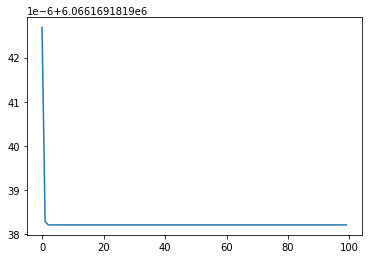

In [158]:
plt.plot(nll_loss)

### Cluster to Label Conversion

In [111]:
def add_label(y, cluster_name):
    num_labels = len(np.unique(y))
    max_corr_pred = -np.inf
    for assignment in it.permutations(range(num_labels)):
        assignment = np.array(assignment)
        corr_pred = np.count_nonzero(y==assignment[cluster_name])
        if corr_pred > max_corr_pred:
            cluster_to_label = assignment
            max_corr_pred = corr_pred
    
    return cluster_to_label, max_corr_pred


### Per Cluster Accuracy

In [112]:
def get_per_class_accuracy(y, y_pred):
    labels = np.unique(y)
    accuracies = np.empty(len(labels))
    for label in labels:
        label_idxs, = np.where(y == label)
        corr_pred = np.count_nonzero(y_pred[label_idxs] == label)
        accuracies[label] = corr_pred / len(label_idxs)

    return accuracies


### Labeling Clusters Using Train Data

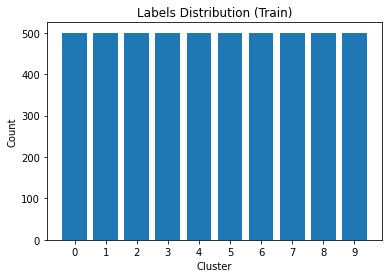

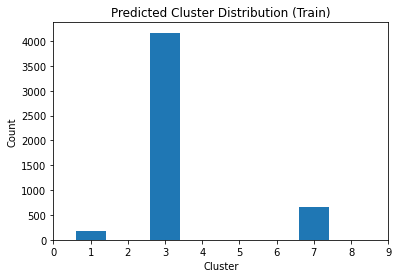

In [121]:
train_labels_predicted = gmm_naive.predict(code_train)

plot_cluster_dist(data_train_labels, 10, "Labels Distribution (Train)")
plot_cluster_dist(train_labels_predicted, 10, "Predicted Cluster Distribution (Train)")

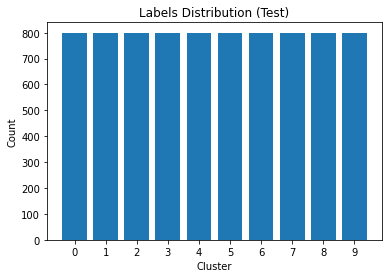

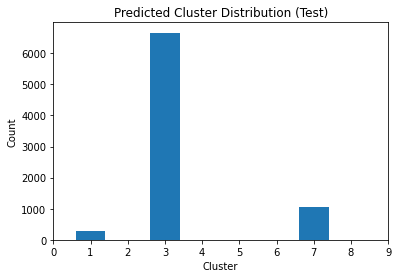

In [122]:
test_labels_predicted = gmm_naive.predict(code_test)

plot_cluster_dist(data_test_labels, 10, "Labels Distribution (Test)")
plot_cluster_dist(test_labels_predicted, 10, "Predicted Cluster Distribution (Test)")

### Adding Labels to Clusters

In [123]:
cluster_to_label, corr_pred = add_label(data_train_labels, train_labels_predicted)
print(f"Accuracy (Train): {corr_pred/len(data_train_labels)*100:.2f}%")

Accuracy (Train): 13.12%


In [124]:
per_class_accuracy = get_per_class_accuracy(data_train_labels, cluster_to_label[train_labels_predicted])
print(f"Cluster Assingments and Accuracies (Train)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments and Accuracies (Train)
Cluster 0: bird, 0.00%
Cluster 1: ship, 5.80%
Cluster 2: cat, 0.00%
Cluster 3: car, 91.20%
Cluster 4: deer, 0.00%
Cluster 5: dog, 0.00%
Cluster 6: horse, 0.00%
Cluster 7: airplane, 34.20%
Cluster 8: monkey, 0.00%
Cluster 9: truck, 0.00%


In [125]:
cluster_to_label, corr_pred = add_label(data_test_labels, test_labels_predicted)
print(f"Accuracy (test): {corr_pred/len(data_test_labels)*100:.2f}%")

Accuracy (test): 13.81%


In [126]:
per_class_accuracy = get_per_class_accuracy(data_test_labels, cluster_to_label[test_labels_predicted])
print(f"Cluster Assingments and Accuracies (Test)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments and Accuracies (Test)
Cluster 0: bird, 0.00%
Cluster 1: ship, 6.50%
Cluster 2: car, 0.00%
Cluster 3: horse, 91.88%
Cluster 4: cat, 0.00%
Cluster 5: deer, 0.00%
Cluster 6: dog, 0.00%
Cluster 7: airplane, 39.75%
Cluster 8: monkey, 0.00%
Cluster 9: truck, 0.00%


### Semi-supervised GMM

In [128]:
mus = np.empty((n_components, optimal_dim))
sigmas = np.empty((n_components, optimal_dim, optimal_dim))
for label in np.unique(data_train_labels):
    mus[label] = code_train[data_train_labels == label].mean(axis=0)
    sigmas[label] = np.cov(code_train.T)

In [133]:
gmm_seeded = GMM(n_components, 100)
nll_loss = gmm_seeded.fit(code_optimal, mus, sigmas, log_interval=10)

[10/100], NLL_Loss: 7159295.893632905
[20/100], NLL_Loss: 7159295.893632905
[30/100], NLL_Loss: 7159295.893632905
[40/100], NLL_Loss: 7159295.893632905
[50/100], NLL_Loss: 7159295.893632905
[60/100], NLL_Loss: 7159295.893632905
[70/100], NLL_Loss: 7159295.893632905
[80/100], NLL_Loss: 7159295.893632905
[90/100], NLL_Loss: 7159295.893632905
[100/100], NLL_Loss: 7159295.893632905


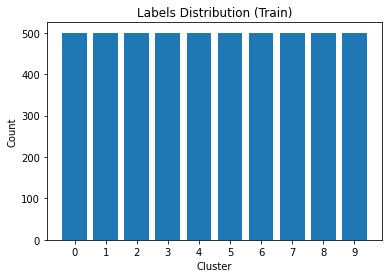

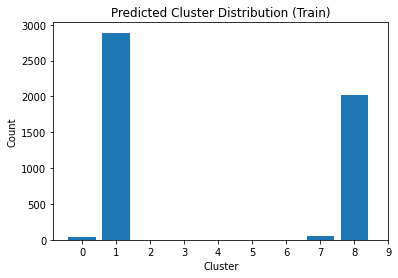

In [134]:
train_labels_predicted = gmm_seeded.predict(code_train)

plot_cluster_dist(data_train_labels, 10, "Labels Distribution (Train)")
plot_cluster_dist(train_labels_predicted, 10, "Predicted Cluster Distribution (Train)")

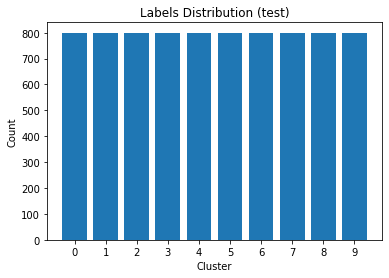

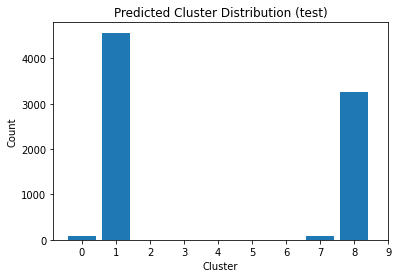

In [135]:
test_labels_predicted = gmm_seeded.predict(code_test)

plot_cluster_dist(data_test_labels, 10, "Labels Distribution (test)")
plot_cluster_dist(test_labels_predicted, 10, "Predicted Cluster Distribution (test)")

In [136]:
print(f"Accuracy (Train): {np.count_nonzero(data_train_labels == train_labels_predicted)/len(data_train_labels)*100:.2f}%")

Accuracy (Train): 18.56%


In [137]:
print(f"Accuracy (Test): {np.count_nonzero(data_test_labels == test_labels_predicted)/len(data_test_labels)*100:.2f}%")

Accuracy (Test): 17.46%


In [138]:
per_class_accuracy = get_per_class_accuracy(data_train_labels, train_labels_predicted)
print(f"Cluster Assingments (Train)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments (Train)
Cluster 0: bird, 86.00%
Cluster 1: ship, 87.40%
Cluster 2: car, 0.00%
Cluster 3: horse, 0.00%
Cluster 4: cat, 0.00%
Cluster 5: deer, 0.00%
Cluster 6: dog, 0.00%
Cluster 7: airplane, 6.20%
Cluster 8: monkey, 6.00%
Cluster 9: truck, 0.00%


In [139]:
per_class_accuracy = get_per_class_accuracy(data_test_labels, test_labels_predicted)
print(f"Cluster Assingments (Test)")
for cluster_idx, class_idx in enumerate(cluster_to_label):
    print(f"Cluster {cluster_idx}: {classes[class_idx]}, {per_class_accuracy[class_idx]*100:.2f}%")

Cluster Assingments (Test)
Cluster 0: bird, 82.50%
Cluster 1: ship, 86.88%
Cluster 2: car, 0.00%
Cluster 3: horse, 0.00%
Cluster 4: cat, 0.00%
Cluster 5: deer, 0.00%
Cluster 6: dog, 0.00%
Cluster 7: airplane, 2.75%
Cluster 8: monkey, 2.50%
Cluster 9: truck, 0.00%


### Generating Samples

In [147]:
weight.shape

(10,)

Text(0.5, 0.98, 'Reconstructed Sampled Data')

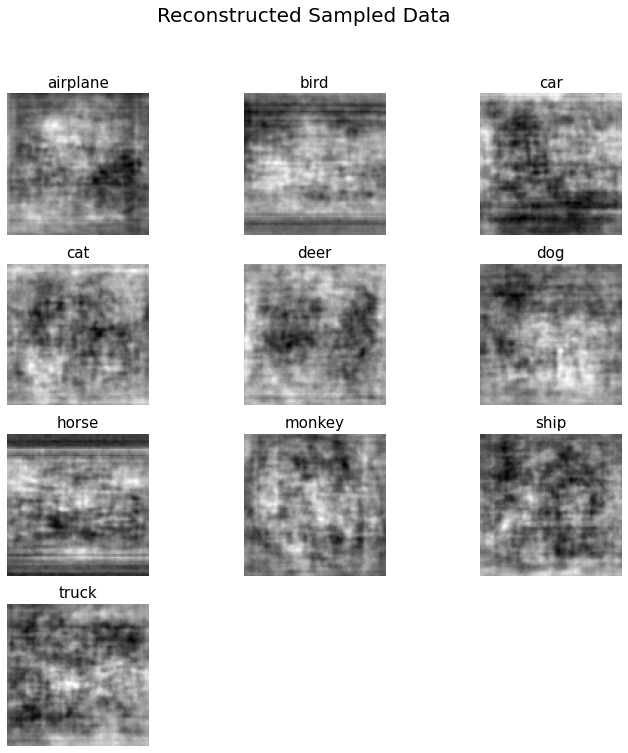

In [159]:
data_sampled = np.empty((10, optimal_dim))
weights = np.eye(10)

for idx, weight in enumerate(weights):
    data_sampled[idx] = gmm_naive.sample(weight)

reconstructed_samples = pca_stl10.reconstruct(data_sampled.T, optimal_dim).T

plt.figure(figsize=(12,12))
for idx, img in enumerate(reconstructed_samples):
    plt.subplot(4, 3, idx+1)
    plt.imshow(img.reshape(96,96), cmap="gray")
    plt.title(np.array(classes)[idx], fontsize=15)
    plt.axis('off')

plt.suptitle("Reconstructed Sampled Data", fontsize=20)


In [151]:
reconstructed_samples.shape

(9216, 10)

## References

<a id='1'>[\[1\] A. Coates, A. Ng, en H. Lee, “An Analysis of Single Layer Networks in Unsupervised Feature Learning”, in AISTATS, 2011.](https://cs.stanford.edu/~acoates/stl10/)</a>  
<a id='2'>[\[2\] M. P. Deisenroth, A. A. Faisal, and C. S. Ong, Mathematics for Machine Learning. Cambridge, United Kingdom: Cambridge University Press, 2020.](https://mml-book.com)</a>  
<a id='3'>[\[3\] Pearson, K. 1901. On lines and planes of closest fit to systems of points in space. Philosophical Magazine 2:559-572](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1056/2012/10/pearson1901.pdf)</a>  
<a id='4'>[\[4\] J. Shlens, “A tutorial on principal component analysis”, arXiv preprint arXiv:1404. 1100, 2014.](https://arxiv.org/abs/1404.1100)</a>  
<a id=''>[\[\] S. Basu, A. Banerjee, en R. Mooney, “Semi-supervised Clustering by Seeding”, 01 2002, bll 27–34.](https://www.cs.utexas.edu/~ml/papers/semi-icml-02.pdf)</a>  
<a id=''>[\[\] ]()</a>  



## Misc
Used for computing projection matrix.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/CoE197M/* .

In [ ]:
del ds_unlabeled, ds_test, ds_train, data_unlabeled_RGB, data_unlabeled, data_test, data_train
import gc
gc.collect(generation=2)

7781

In [63]:
!cp *.npy drive/MyDrive/CoE197M
drive.flush_and_unmount()

### Testing GMM Bivariate Gaussian

[10/300], NLL_Loss: 2357.9931579610247
[20/300], NLL_Loss: 2357.9931579610247
[30/300], NLL_Loss: 2357.9931579610247
[40/300], NLL_Loss: 2357.9931579610247
[50/300], NLL_Loss: 2357.9931579610247
[60/300], NLL_Loss: 2357.9931579610247
[70/300], NLL_Loss: 2357.9931579610247
[80/300], NLL_Loss: 2357.9931579610247
[90/300], NLL_Loss: 2357.9931579610247
[100/300], NLL_Loss: 2357.9931579610247
[110/300], NLL_Loss: 2357.9931579610247
[120/300], NLL_Loss: 2357.9931579610247
[130/300], NLL_Loss: 2357.9931579610247
[140/300], NLL_Loss: 2357.9931579610247
[150/300], NLL_Loss: 2357.9931579610247
[160/300], NLL_Loss: 2357.9931579610247
[170/300], NLL_Loss: 2357.9931579610247
[180/300], NLL_Loss: 2357.9931579610247
[190/300], NLL_Loss: 2357.9931579610247
[200/300], NLL_Loss: 2357.9931579610247
[210/300], NLL_Loss: 2357.9931579610247
[220/300], NLL_Loss: 2357.9931579610247
[230/300], NLL_Loss: 2357.9931579610247
[240/300], NLL_Loss: 2357.9931579610247
[250/300], NLL_Loss: 2357.9931579610247
[260/300]

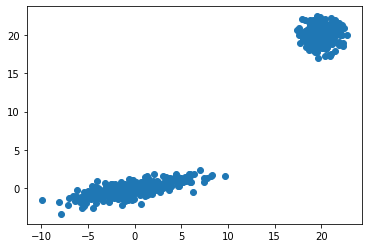

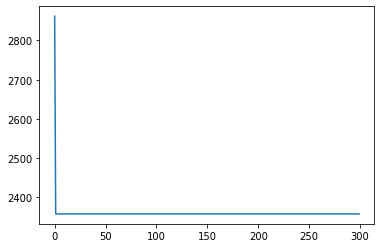

In [41]:
n_samples = 300
n_components = 2

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

from sklearn.cluster import KMeans

# k=2
# kmeans = KMeans(n_clusters=k)
# X_dist = kmeans.fit_transform(X_train) 
# representative_idx = np.argmin(X_dist, axis=0) 
# X_representative = X_train[representative_idx]

# print(X_dist)
# print(kmeans.labels_)
# print(representative_idx)

gmm = GMM(n_components, 300)
nll_loss = gmm.fit(X_train, np.array([X_train[0], X_train[-1]]))


plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1])

np.set_printoptions(precision=3, suppress=True)
plt.figure()
plt.plot(nll_loss)
print(gmm.mus)
print(gmm.sigmas)

In [42]:
sample0 = gmm.sample(np.array([1, 0]))
sample1 = gmm.sample(np.array([0, 1]))
sample2 = gmm.sample(np.array([1, 1]))
print(sample0, sample1, sample2)

[21.076 20.004] [2.634 0.914] [ 9.608 10.058]


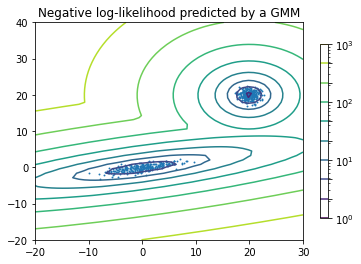

In [43]:
# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
XX.shape
probs = logsumexp(gmm.log_probabilities(XX), axis=1)
# eps = 1e-200
# probs[probs < eps] = eps
probs = -probs

Z = probs.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
# norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()